In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

%matplotlib inline

In [2]:
#nltk.download('punkt')

In [3]:
data = pd.read_csv("output_merged_25oct.csv", encoding='latin-1')
data.head()

,COMPANY,COUNTRY,DISTRIBUTOR,ARTICLE ID,MODEL NUMBER,ARTICLE NAME,SUBBRAND,SPORTS CATEGORY,PRODUCT DIVISION,PRODUCT GROUP,...,CURRENT PRICE IN EUR,INITIAL PRICE IN SELECTED CURRENCY,CURRENT PRICE IN SELECTED CURRENCY,SELECTED CURRENCY,PRODUCT INTRODUCTION DATE,DISCOUNTED SINCE,PRODUCT EXIT DATE,PRODUCT DESCRIPTION,PRODUCT URL,IMAGE-SERVER URL
0,Nike,USA,Own eCom,837786-603,837786,KD 8 'Aunt Pearl' Premium Big Kids' Basketball...,Performance,Basketball,Footwear,Performance Footwear,...,56.5239,121.80,56.5239,EUR,2/29/2016,11/9/2016,9/18/2017,DYNAMIC VERSATILITY. INSPIRED STYLE.; The KD 8...,https://store.nike.com/us/en_us/pd/kd-8-aunt-p...,http://usporamap287.am.adsint.biz/zoomimages/1...
1,Nike,USA,Own eCom,810455-421,810455,LeBron 13 Transportation Kids' Adjustable Hat,Sport Inspired,Lifestyle,Accessories,Headwear,...,17.3739,24.36,17.3739,EUR,2/29/2016,4/4/2016,5/2/2016,LEBRON TRANSPORTATION HAT The LeBron 13 Transp...,http://store.nike.com/us/en_us/pd/lebron-13-tr...,http://usporamap287.am.adsint.biz/zoomimages/1...
2,Nike,USA,Own eCom,807940-010,807940,Nike SB Cherry Blossom Perforated Trucker Hat,Sport Inspired,Skate,Accessories,Headwear,...,27.8400,27.84,27.8400,EUR,2/29/2016,Not discounted yet,3/21/2016,BREATHABLE COMFORT The Nike SB Cherry Blossom ...,http://store.nike.com/us/en_us/pd/sb-cherry-bl...,http://usporamap287.am.adsint.biz/zoomimages/1...
3,Nike,USA,Own eCom,749502-100,749502,Nike Cortez Big Kids' Shoe,Sport Inspired,Lifestyle,Footwear,Sport Inspired Footwear,...,39.1239,52.20,39.1239,EUR,2/29/2016,2/9/2017,4/10/2017,"A CLASSIC, REBORN. The Nike Cortez BigÂ Kids' ...",http://store.nike.com/us/en_us/pd/cortez-big-k...,http://usporamap287.am.adsint.biz/zoomimages/1...
4,Nike,USA,Own eCom,746735-404,746735,Nike Golf AW84 OX Adjustable Hat,Performance,Golf,Accessories,Headwear,...,17.3739,20.88,17.3739,EUR,2/29/2016,6/30/2016,10/10/2016,PREMIUM LOOK. LIGHTWEIGHT FIT. The Nike Golf A...,http://store.nike.com/us/en_us/pd/golf-aw84-ox...,http://usporamap287.am.adsint.biz/zoomimages/1...


In [4]:
data.isnull().sum()

COMPANY                                    0
COUNTRY                                    0
DISTRIBUTOR                                0
ARTICLE ID                                 0
MODEL NUMBER                               0
ARTICLE NAME                              19
SUBBRAND                                   0
SPORTS CATEGORY                            0
PRODUCT DIVISION                           0
PRODUCT GROUP                              0
PRODUCT TYPE                               0
FRANCHISE                                 20
TECHNOLOGIES                          146388
COLOUR GROUP                               0
COLOUR                                  7285
GENDER                                     0
AGE GROUP                                  0
CONSUMER RATING                            0
INITIAL PRICE IN LOCAL CURRENCY            0
CURRENT PRICE IN LOCAL CURRENCY            0
LOCAL CURRENCY                             0
INITIAL PRICE IN EUR                       0
CURRENT PR

In [5]:
data.COUNTRY.unique()

array(['USA', 'Germany', 'Japan'], dtype=object)

In [6]:
data['PRODUCT GROUP'].unique()

array(['Performance Footwear', 'Headwear', 'Sport Inspired Footwear',
       'Socks', 'Bags', 'Sport Equipment', 'Cleated Footwear',
       'Other Accessories', 'Protective Gear', 'Scarves', 'Gloves',
       'Spikes', 'Pants & Tights', 'Shirts & Polos', 'Tracksuits',
       'Sandals & Flip Flops', 'Glasses', 'Watches', 'Jerseys', 'Shorts',
       'Jackets & Vests', 'Underwear', 'Sweatshirts & Hoodies',
       'Swimwear', 'Skirts & Dresses'], dtype=object)

In [7]:
# Filtering US and UK
#data = data.loc[data["language"].isin(['de-DE'])]

In [8]:
#data.group.unique()

In [9]:
data_req = data.loc[:,["COMPANY", "COUNTRY", "ARTICLE NAME","PRODUCT GROUP", "PRODUCT DESCRIPTION", "PRODUCT URL"]]

In [10]:
data_req = data_req.drop_duplicates()

In [11]:
len(data_req)

268673

In [12]:
data_req_x = data_req.loc[:,["COMPANY", "COUNTRY", "ARTICLE NAME", "PRODUCT DESCRIPTION", "PRODUCT URL"]]
data_req_y = data_req.loc[:, ["PRODUCT GROUP"]]

In [13]:
data_req_x = data_req_x.fillna("unknown")
data_req = pd.concat([data_req_x, data_req_y], axis=1)

In [14]:
len(data_req)

268673

In [15]:
data_req = data_req.dropna()

In [16]:
data_req = data_req.drop_duplicates()

In [17]:
data_req["description"]  = data_req["COMPANY"] +" " + data_req["COUNTRY"] +" " + data_req["ARTICLE NAME"] +" " + data_req["PRODUCT DESCRIPTION"]+" " + data_req["PRODUCT URL"]

In [18]:
data_req = data_req.drop(["COMPANY", "COUNTRY", "ARTICLE NAME", "PRODUCT DESCRIPTION", "PRODUCT URL"], axis = 1)

In [19]:
data_req.columns = ["subBrand", "description"]

In [20]:
data_req.subBrand.unique()

array(['Performance Footwear', 'Headwear', 'Sport Inspired Footwear',
       'Socks', 'Bags', 'Sport Equipment', 'Cleated Footwear',
       'Other Accessories', 'Protective Gear', 'Scarves', 'Gloves',
       'Spikes', 'Pants & Tights', 'Shirts & Polos', 'Tracksuits',
       'Sandals & Flip Flops', 'Glasses', 'Watches', 'Jerseys', 'Shorts',
       'Jackets & Vests', 'Underwear', 'Sweatshirts & Hoodies',
       'Swimwear', 'Skirts & Dresses'], dtype=object)

In [21]:
len(data_req)

268673

In [22]:
data_req = data_req.drop_duplicates()

In [23]:
data_req.subBrand = data_req.subBrand.str.lower()
data_req.description = data_req.description.str.lower()

In [24]:
data_req.subBrand.unique()

array(['performance footwear', 'headwear', 'sport inspired footwear',
       'socks', 'bags', 'sport equipment', 'cleated footwear',
       'other accessories', 'protective gear', 'scarves', 'gloves',
       'spikes', 'pants & tights', 'shirts & polos', 'tracksuits',
       'sandals & flip flops', 'glasses', 'watches', 'jerseys', 'shorts',
       'jackets & vests', 'underwear', 'sweatshirts & hoodies',
       'swimwear', 'skirts & dresses'], dtype=object)

In [25]:
lens = data_req.description.str.len()
lens.mean(), lens.std(), lens.max()

(680.0936752111303, 432.91238396741073, 6086)

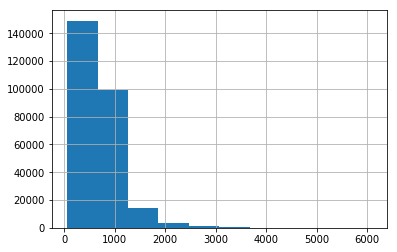

In [26]:
lens.hist();

In [27]:
data_req = data_req.dropna()

In [28]:
len(data_req)

268673

In [29]:
one_hot = pd.get_dummies(data_req.subBrand)

In [30]:
label_cols = data_req.subBrand.dropna().unique()

In [31]:
label_cols

array(['performance footwear', 'headwear', 'sport inspired footwear',
       'socks', 'bags', 'sport equipment', 'cleated footwear',
       'other accessories', 'protective gear', 'scarves', 'gloves',
       'spikes', 'pants & tights', 'shirts & polos', 'tracksuits',
       'sandals & flip flops', 'glasses', 'watches', 'jerseys', 'shorts',
       'jackets & vests', 'underwear', 'sweatshirts & hoodies',
       'swimwear', 'skirts & dresses'], dtype=object)

In [32]:
minCount = 10
subBrand_minCount = pd.DataFrame((data_req.subBrand.value_counts() > minCount).reset_index())

In [33]:
subBrand_drop = subBrand_minCount.loc[subBrand_minCount["subBrand"] == False]

In [34]:
subBrand_drop

,index,subBrand


In [35]:
label_cols = np.setdiff1d(label_cols, subBrand_drop["index"])

In [36]:
data_req = pd.concat([data_req, one_hot], axis=1)

In [37]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [38]:
description = "description"

In [39]:
data_req = data_req.drop(subBrand_drop["index"], axis = 1)

In [40]:
np.random.seed(123)
data_req_sample = data_req.sample(frac=0.7)

In [41]:
train = data_req.loc[data_req.index.isin(data_req_sample.index)]
test = data_req.loc[~data_req.index.isin(data_req_sample.index)]

In [42]:
test_subBrand = test.subBrand

In [43]:
#test_subBrand

In [44]:
train = train.drop("subBrand", axis = 1)
test = test.drop("subBrand", axis = 1)

In [45]:
# token_dict = {}
# stemmer = PorterStemmer()

# def stem_tokens(tokens, stemmer):
#     stemmed = []
#     for item in tokens:
#         stemmed.append(stemmer.stem(item))
#     return stemmed

# def tokenize(text):
#     tokens = nltk.word_tokenize(text)
#     stems = stem_tokens(tokens, stemmer)
#     return stems

In [46]:
# from stop_words import get_stop_words
# stop_words_english = get_stop_words('english')
# stop_words_german = get_stop_words('german')

In [47]:
#stop_words_english.append(stop_words_german)

In [48]:
# stop_words_english = sorted(set(map(tuple, stop_words_english)), reverse=True)

In [49]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)
trn_term_doc = vec.fit_transform(train[description])
test_term_doc = vec.transform(test[description])

In [50]:
trn_term_doc, test_term_doc

(<188071x636139 sparse matrix of type '<class 'numpy.float64'>'
 	with 34486101 stored elements in Compressed Sparse Row format>,
 <80602x636139 sparse matrix of type '<class 'numpy.float64'>'
 	with 14559385 stored elements in Compressed Sparse Row format>)

In [51]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [52]:
x = trn_term_doc
test_x = test_term_doc

In [53]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit bags
fit cleated footwear
fit glasses
fit gloves
fit headwear
fit jackets & vests
fit jerseys
fit other accessories
fit pants & tights
fit performance footwear
fit protective gear
fit sandals & flip flops
fit scarves
fit shirts & polos
fit shorts
fit skirts & dresses
fit socks
fit spikes
fit sport equipment
fit sport inspired footwear
fit sweatshirts & hoodies
fit swimwear
fit tracksuits
fit underwear
fit watches


In [58]:
preds.shape

(80602, 25)

In [59]:
predictions = pd.DataFrame(preds, columns = label_cols)

In [60]:
test.index = np.arange(0, len(test))
test_subBrand.index = np.arange(0, len(test))

In [61]:
len(test)

80602

In [62]:
submid = pd.DataFrame({'description': test["description"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)

In [63]:
submission.head()

,description,bags,cleated footwear,glasses,gloves,headwear,jackets & vests,jerseys,other accessories,pants & tights,...,skirts & dresses,socks,spikes,sport equipment,sport inspired footwear,sweatshirts & hoodies,swimwear,tracksuits,underwear,watches
0,"nike usa nike cortez big kids' shoe a classic,...",0.000124,0.000362,0.000035,0.000075,0.000135,0.000265,0.000090,0.000061,0.000076,...,0.000096,0.000099,0.000089,0.000190,0.985698,0.000150,0.000054,0.000083,0.000134,0.000027
1,nike germany nike performance low-cut socken f...,0.000112,0.000246,0.000039,0.000168,0.000500,0.000852,0.000168,0.000098,0.002240,...,0.000168,0.999859,0.000076,0.000464,0.000437,0.000685,0.000105,0.000167,0.000349,0.000028
2,nike usa nike jr. tiempo legend vi tf kids' tu...,0.000108,0.999974,0.000039,0.000088,0.000118,0.000273,0.000117,0.000068,0.000040,...,0.000109,0.000135,0.000162,0.000330,0.000807,0.000086,0.000071,0.000092,0.000094,0.000027
3,nike usa nike mercurial victory v tf kids' tur...,0.000176,1.000000,0.000040,0.000117,0.000294,0.000314,0.000373,0.000081,0.000334,...,0.000188,0.000160,0.000086,0.001362,0.000540,0.000318,0.000071,0.000131,0.000161,0.000028
4,nike usa nike jr. mercurial victory v ic kids'...,0.000102,0.994488,0.000039,0.000104,0.000119,0.000049,0.000216,0.000075,0.000069,...,0.000138,0.000131,0.000119,0.000993,0.008406,0.000134,0.000079,0.000096,0.000126,0.000027


In [64]:
final_pred = pd.concat([submission, test_subBrand.str.lower()],axis = 1)

In [65]:
test_subBrand.str.lower().value_counts()

shirts & polos             18526
sport inspired footwear    12971
performance footwear        9384
pants & tights              6555
jackets & vests             6155
shorts                      4810
sweatshirts & hoodies       3543
cleated footwear            2927
headwear                    2765
bags                        2628
jerseys                     1788
socks                       1713
underwear                   1333
sport equipment             1052
skirts & dresses             796
tracksuits                   767
sandals & flip flops         543
spikes                       501
gloves                       487
swimwear                     348
other accessories            291
glasses                      281
protective gear              181
watches                      146
scarves                      111
Name: subBrand, dtype: int64

In [67]:
data["PRODUCT GROUP"].value_counts()

Shirts & Polos             62494
Sport Inspired Footwear    43688
Performance Footwear       31732
Pants & Tights             21999
Jackets & Vests            20293
Shorts                     16150
Sweatshirts & Hoodies      11661
Cleated Footwear            9976
Headwear                    9390
Bags                        9012
Jerseys                     5891
Socks                       5752
Underwear                   4550
Sport Equipment             3575
Skirts & Dresses            2614
Tracksuits                  2564
Sandals & Flip Flops        1858
Spikes                      1697
Gloves                      1653
Swimwear                    1158
Other Accessories           1062
Glasses                      977
Protective Gear              595
Watches                      475
Scarves                      349
Name: PRODUCT GROUP, dtype: int64

In [68]:
final_pred["Predictions"] = final_pred[label_cols].idxmax(axis = 1)

In [69]:
from mlxtend.evaluate import confusion_matrix

y_target =    final_pred.subBrand
y_predicted = final_pred.Predictions

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted, 
                      binary=False)

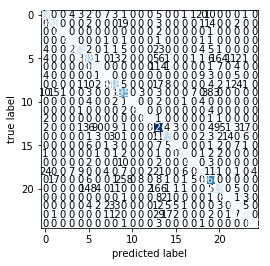

In [70]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [71]:
print(f'Accuracy Score : {accuracy_score(final_pred.subBrand, final_pred.Predictions)}')
print(f'F1 Score: {f1_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')
print(f'Precision: {precision_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')
print(f'Recall: {recall_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')

Accuracy Score : 0.9698890846380983
F1 Score: 0.9629627194299311
Precision: 0.9687432765797074
Recall: 0.9574713849562723


In [72]:
final_pred.to_csv("final_output_product_group.csv", index_label=False, index=False)

In [83]:
len(final_pred)

20860

In [51]:
#test_subBrand

In [52]:
len(submission)

15062

In [54]:
#final_pred.isnull().sum()